## Topic Trends final code - Coronavirus

This code was created from Martha and Sean's emerging topic code and was used to create the hottest/coldest topics static graphics for the full, pandemics, and coronavirus corpora.

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time
import re

from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression as lm
from scipy import stats

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

import seaborn as sns

### Data Ingestion

In [2]:
# full corpus
#df = pd.read_pickle("../../data/final/final_dataset_7-20.pkl")

# pandemic corpus
df = pd.read_pickle("../../../../data/prd/Tech-Report/case_studies/coronavirus_corpus.pkl")
df.reset_index(inplace=True)

# coronavirus corpus -- NEED TO CREATE
#df = pd.read_pickle("/home/kjl5t/dspg20RnD/data/final/dashboard_data/corona_corpus.pkl")
#df.reset_index(inplace=True)

In [3]:
df.head()

,level_0,index,original index,PROJECT_ID,ABSTRACT,FY,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS,ORG_COUNT,PI_COUNT,final_tokens
0,5122,5122,5608,95622,Host - virus interactions are greatly affected...,2008,Affect; Antiviral Agents; Area; Biochemical; D...,THE ROLE OF A HOST ION PUMP IN RNA VIRUS RECOM...,NSF,NSF,NaN,0817790,8/15/2008,7/31/2012,"NAGY, PETER D",NaN,00,007400724,UNIVERSITY OF KENTUCKY,LEXINGTON,KY,40506-0057,UNITED STATES,NaN,NaN,47.074,2008,612000.0,NaN,1,1,"[host, virus, interaction, greatly, affect, ex..."
1,13938,13938,15726,152221,AbstractThe American Society for Virology (ASV...,2008,abstracting; Acquired Immunodeficiency Syndrom...,"INTERNATIONAL CONGRESS OF VIROLOGY, ISTANBUL, ...",HHS,NIH,NIAID,1R13AI075719-01,2/1/2008,1/31/2009,"SAWICKI, DOROTHEA L",NaN,09,807418939,UNIVERSITY OF TOLEDO HEALTH SCI CAMPUS,TOLEDO,OH,436142595,UNITED STATES,2/1/2008,1/31/2009,93.855,2008,30000.0,NaN,1,1,"[american, society, virology_asv, wish, provid..."
2,14418,14418,17118,153617,DESCRIPTION (provided by applicant): Severe a...,2008,Abbreviations; Address; Alleles; Alphavirus; A...,SARS REVERSE GENETICS,HHS,NIH,NIAID,5R01AI059136-05,2/15/2004,1/31/2010,"BARIC, RALPH S",NaN,04,608195277,UNIVERSITY OF NORTH CAROLINA CHAPEL HILL,CHAPEL HILL,NC,275990001,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,271608.0,NaN,1,1,"[severe, acute, respiratory, syndrome, life_th..."
3,14514,14514,17384,153888,DESCRIPTION (provided by applicant): Human cor...,2008,Acute; Age-Years; Antigens; Archives; base; Bi...,EPIDEMIOLOGY AND CLINICAL FEATURES OF HUMAN CO...,HHS,NIH,NIAID,5R03AI068069-02,2/1/2007,1/31/2010,"WILLIAMS, JOHN V",NaN,05,965717143,VANDERBILT UNIVERSITY,NASHVILLE,TN,372407749,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,75292.0,NaN,1,1,"[human, coronaviruse_hcov, initially, identify..."
4,14565,14565,17526,154033,"DESCRIPTION: Plus-stranded RNA viruses, which ...",2008,Affect; Agriculture; Animals; Antiviral Agents...,ROLES OF HOST RNA BINDING PROTEINS IN VIRUS RE...,HHS,NIH,NIAID,5R21AI072170-02,2/1/2007,1/31/2010,"NAGY, PETER",NaN,06,939017877,UNIVERSITY OF KENTUCKY,LEXINGTON,KY,405260001,UNITED STATES,2/1/2008,1/31/2010,93.855,2008,200124.0,NaN,1,1,"[strand, rna, virus, pose, significant, risk, ..."


In [4]:
# input needed for LDA, NMF (all from Scikit-Learn) is one string per document (not a list of strings)

text = []
docs = df["final_tokens"]

for abstract in docs:
    text.append(" ".join(abstract))

### Functions needed for all models

In [5]:
# function slightly modified from https://nlpforhackers.io/topic-modeling/

def print_topics(topic_term_mat, vectorizer, top_n=10):
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
        print("\nTopic %d:" % (idx))
        #print([(vectorizer.get_feature_names()[i], topic[i])  # printing out words corresponding to indices found in next line
                        #for i in topic.argsort()[:-top_n - 1:-1]])  # finding indices of top words in topic
            
        print_list = [(vectorizer.get_feature_names()[i], topic[i])  
                        for i in topic.argsort()[:-top_n - 1:-1]]
        for item in print_list:
            print(item)
        

In [6]:
# Function to format topics as a "list of list of strings".
# Needed for topic coherence function in Gensim

# function modified from https://nlpforhackers.io/topic-modeling/

def str_topics(topic_term_mat, vectorizer, top_n=10):

    #input. top_n: how many words to list per topic.  If -1, then list all words.
       
    topic_words = []
    
    for idx, topic in enumerate(topic_term_mat):  # loop through each row of H.  idx = row index.  topic = actual row
            
        if top_n == -1:   
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[::-1]])
        else:
            topic_words.append([vectorizer.get_feature_names()[i] for i in topic.argsort()[:-top_n - 1:-1]])
    
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))    
    
    return str_wds 

### NMF

- Pandemic Model: pandemic dataset, 30, random_state = 1
- Coronavirus Model: coronavirus dataset, 25, random_state = 1

In [7]:
# use for full dataset
#tfidf_vectorizer = TfidfVectorizer(max_df=0.6, min_df=20, lowercase=False, max_features=int(len(docs)/2))
#tf_idf = tfidf_vectorizer.fit_transform(text)

stop_wds = ['research', 'study', 'project']

# use for pandemic or coronavirus dataset
tfidf_vectorizer = TfidfVectorizer(max_df=1.0, min_df=3, lowercase=False, stop_words=stop_wds)
tf_idf = tfidf_vectorizer.fit_transform(text)


In [8]:
# create model

num_topics = 25 

t1 = time.time()
nmf_model = NMF(n_components=num_topics, random_state = 1)
doc_topic = nmf_model.fit_transform(tf_idf)
t2 = time.time()
print(f"  Model time: {t2-t1}")

topic_term = nmf_model.components_

  Model time: 3.059013605117798


In [9]:
print_topics(topic_term, tfidf_vectorizer, 10)


Topic 0:
('replication', 1.3504304416929576)
('rna', 1.3350147577790934)
('protein', 1.3044787632797934)
('viral', 0.9253765045881905)
('host', 0.8808893863796553)
('coronavirus', 0.6041805357556778)
('factor', 0.4324151990068655)
('interaction', 0.42478952061875314)
('target', 0.38286416981564214)
('cellular', 0.3815882840222241)

Topic 1:
('immune', 1.4679701515601962)
('polygenic', 0.9560642847423532)
('trait', 0.7515794304961744)
('regulate', 0.7200917388641049)
('response', 0.6022644709140812)
('protective', 0.5543867424986291)
('immunity', 0.5458349271400874)
('kinetic', 0.48331884276384995)
('phenotype', 0.4516829204079879)
('diverse', 0.42309853774212364)

Topic 2:
('influenza', 1.6484545442026162)
('virus', 0.8963847487360471)
('1918', 0.500302908963027)
('pandemic', 0.4167995675948467)
('human', 0.2932431061703752)
('strain', 0.2741101469571246)
('2009', 0.2388251880464487)
('avian', 0.22227539485489647)
('autopsy', 0.2095983977105023)
('people', 0.20900647358207938)

Topic 

### Topic Trends

In [10]:
# Extract Year from PROJECT_START_DATE

#On our graphs, we want to be able to show year. Therefore, this getYear function gets the year from different date formats from Project Start Year/End Year

#START

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [11]:
sum(df['PROJECT_START_DATE'].isna())

0

In [12]:
df['START_YEAR'].value_counts(dropna=False)

2009    118
2008     98
2011     97
2010     81
2012     70
2013     70
2014     69
2015     69
2016     64
2018     54
2017     47
2007     39
2019     30
2005     21
2004     20
2006     14
2001      9
1983      7
1991      6
1985      5
1977      5
2002      5
2000      3
1976      3
1999      3
1998      3
2003      3
1980      2
1975      2
1988      2
1990      1
1979      1
1994      1
Name: START_YEAR, dtype: int64

In [13]:
#Pulls sample data subsetted by year then takes mean theta for each abstract

topic_frame = pd.DataFrame(doc_topic, columns=["Topic"+" "+str(i) for i in range(num_topics)])
topic_frame["START_YEAR"] = df["START_YEAR"]


#### compute count of projects with weight > 0 for each topic

In [14]:
topic_proj_count = topic_frame.copy()

In [15]:
topic_proj_count.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,START_YEAR
0,0.049164,0.001682,0.00000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002169,0.000799,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.015854,0.178167,0.068924,2008
1,0.009344,0.000000,0.00480,0.003847,0.0,0.000000,0.000000,0.019757,0.003106,0.002268,0.003423,0.000000,0.000000,0.001711,0.012916,0.000000,0.0,0.000000,0.000000,0.000000,0.035499,0.000000,0.066699,0.050431,0.000630,2008
2,0.020296,0.000000,0.00000,0.090674,0.0,0.000000,0.035705,0.000000,0.016689,0.000000,0.007691,0.010036,0.005441,0.000000,0.003148,0.007401,0.0,0.000000,0.015461,0.000000,0.031397,0.038646,0.024805,0.057752,0.000000,2004
3,0.004930,0.001056,0.00932,0.005426,0.0,0.000582,0.001240,0.000275,0.000374,0.000727,0.006824,0.004845,0.008219,0.000000,0.000000,0.001283,0.0,0.000000,0.001154,0.001993,0.008728,0.086931,0.134644,0.000000,0.000000,2007
4,0.138960,0.000000,0.00000,0.000000,0.0,0.000000,0.003647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.005975,0.000000,0.000000,0.000000,0.000000,0.000000,0.135313,0.000000,2007


In [16]:
topic_count_bool = (topic_proj_count.iloc[:,0:num_topics] > 0)
topic_count_bool["START_YEAR"] = topic_proj_count["START_YEAR"]

In [17]:
topic_count_bool

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24,START_YEAR
0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,False,False,False,False,False,True,True,True,2008
1,True,False,True,True,False,False,False,True,True,True,True,False,False,True,True,False,False,False,False,False,True,False,True,True,True,2008
2,True,False,False,True,False,False,True,False,True,False,True,True,True,False,True,True,False,False,True,False,True,True,True,True,False,2004
3,True,True,True,True,False,True,True,True,True,True,True,True,True,False,False,True,False,False,True,True,True,True,True,False,False,2007
4,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,2019
1018,True,True,True,False,False,False,True,False,True,True,False,True,False,False,True,True,False,True,False,False,True,False,False,True,True,2017
1019,True,True,True,False,True,False,False,True,False,True,False,False,False,True,True,True,True,False,True,True,False,False,True,True,False,2018
1020,True,True,True,True,True,False,True,True,False,False,False,False,False,True,False,False,False,True,True,True,False,True,False,True,True,2017


In [18]:
topic_count_bool.sum(axis=1).median()

10.0

In [19]:
# same calculation but grouped by year

topic_counts = topic_count_bool.groupby("START_YEAR").sum().reset_index()
topic_counts = topic_counts.sort_values(by = "START_YEAR")  # pretty sure this is unnecessary
topic_counts["START_YEAR"] = topic_counts["START_YEAR"].astype(int)


In [20]:
#topic_counts

In [21]:
topic_counts_filt = topic_counts[topic_counts["START_YEAR"] > 2009] 
topic_counts_filt = topic_counts_filt[topic_counts_filt["START_YEAR"] < 2020]

In [22]:
topic_counts_filt

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
23,2010,39,27,33,33,31,28,33,24,38,29,32,23,31,20,28,41,28,26,32,29,25,37,38,43,29
24,2011,57,40,49,41,43,29,21,43,27,27,41,36,33,33,29,25,30,32,38,24,31,41,46,61,34
25,2012,28,28,36,30,36,24,27,29,25,29,16,18,15,25,21,24,25,28,28,21,26,32,25,42,20
26,2013,29,32,31,25,23,23,30,24,17,28,26,15,18,18,24,25,23,27,28,20,20,31,33,41,17
27,2014,35,30,28,24,17,20,27,30,19,29,22,18,22,20,28,22,20,28,29,26,20,26,30,40,23
28,2015,33,27,34,29,27,17,25,35,20,34,20,21,20,24,27,27,24,25,29,27,23,23,25,37,20
29,2016,26,28,23,23,18,11,19,14,16,31,19,14,22,14,26,25,18,26,15,25,16,23,28,35,24
30,2017,24,26,22,17,19,15,26,21,13,20,18,11,15,21,21,23,10,21,18,19,13,19,24,30,19
31,2018,23,27,21,18,22,21,19,29,11,13,19,21,20,22,22,25,17,27,21,31,11,20,21,29,24
32,2019,14,13,11,13,14,9,10,11,7,10,12,11,9,12,11,11,12,15,10,16,7,13,14,19,14


In [23]:
n_by_topic = topic_counts_filt.sum()[1:]

n_by_topic

Topic 0     308
Topic 1     278
Topic 2     288
Topic 3     253
Topic 4     250
Topic 5     197
Topic 6     237
Topic 7     260
Topic 8     193
Topic 9     250
Topic 10    225
Topic 11    188
Topic 12    205
Topic 13    209
Topic 14    237
Topic 15    248
Topic 16    207
Topic 17    255
Topic 18    248
Topic 19    238
Topic 20    192
Topic 21    265
Topic 22    284
Topic 23    377
Topic 24    224
dtype: int64

In [24]:
n_by_topic[0]

308

#### compute dollars by topic by year

#### calculate mean topic weight by year and standard errors on means

In [25]:
topic_frame_se = topic_frame.groupby("START_YEAR").sem().reset_index()
topic_frame_se = topic_frame_se.sort_values(by = "START_YEAR")
topic_frame_se["START_YEAR"] = topic_frame_se["START_YEAR"].astype(int)

topic_wts_se_2010_2019 = topic_frame_se[topic_frame_se["START_YEAR"] > 2009] 
topic_wts_se_2010_2019 = topic_wts_se_2010_2019[topic_wts_se_2010_2019["START_YEAR"] < 2020]

In [26]:
topic_frame = topic_frame.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [27]:
topic_frame.head()

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
0,1975,0.003993,0.000000,0.000000,0.000000,0.00000,0.027736,0.000000,0.000000,0.027195,0.000000,0.106849,0.020801,0.053415,0.000000,0.000000,0.000000,0.000000,0.004781,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1976,0.000000,0.000000,0.002732,0.000000,0.00000,0.000000,0.000000,0.020805,0.002316,0.005932,0.127977,0.001521,0.063956,0.000000,0.004027,0.000000,0.000000,0.000000,0.001989,0.000000,0.014063,0.010131,0.001861,0.085194,0.000000
2,1977,0.049612,0.000000,0.034993,0.003929,0.00000,0.004620,0.002654,0.001417,0.000814,0.013179,0.100283,0.001122,0.004570,0.000000,0.000230,0.001292,0.046533,0.003271,0.004584,0.002351,0.002671,0.004013,0.002148,0.005141,0.000000
3,1979,0.125856,0.000834,0.004602,0.000000,0.00000,0.000000,0.019905,0.000000,0.000000,0.000000,0.018105,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.014472,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,1980,0.000000,0.000000,0.016673,0.012273,0.06491,0.000000,0.000000,0.018316,0.000000,0.000000,0.012654,0.000000,0.014104,0.051589,0.000000,0.000000,0.006949,0.000000,0.062041,0.000000,0.000000,0.000000,0.000000,0.015684,0.023686


In [28]:
# filter topic_frame for years 2010 - 2019

topic_wts_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_wts_2010_2019 = topic_wts_2010_2019[topic_wts_2010_2019["START_YEAR"] < 2020] 

In [29]:
topic_wts_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
23,2010,0.013263,0.002602,0.016952,0.011373,0.011042,0.011967,0.003314,0.006063,0.020499,0.004100,0.033502,0.008281,0.017319,0.015245,0.005350,0.011315,0.016324,0.007122,0.009064,0.004622,0.008700,0.017596,0.025998,0.034151,0.012680
24,2011,0.010552,0.002685,0.020289,0.013226,0.016570,0.010375,0.004124,0.014539,0.006722,0.001999,0.022278,0.012551,0.011282,0.013569,0.007033,0.006027,0.019126,0.006041,0.023366,0.001903,0.008533,0.014184,0.021307,0.038705,0.013967
25,2012,0.011699,0.019700,0.037118,0.019011,0.020213,0.012366,0.006899,0.007725,0.007814,0.004496,0.006477,0.011283,0.007480,0.013376,0.004064,0.007621,0.016844,0.008308,0.012711,0.003635,0.010019,0.018283,0.014769,0.042683,0.011596
26,2013,0.010237,0.018031,0.021988,0.012344,0.018238,0.005316,0.022867,0.006503,0.005787,0.006076,0.004791,0.010025,0.008587,0.009219,0.006425,0.010494,0.019360,0.017804,0.014621,0.006204,0.010297,0.020680,0.022513,0.038430,0.005182
27,2014,0.010338,0.017222,0.016558,0.012456,0.002229,0.007778,0.015363,0.012583,0.007551,0.019590,0.007090,0.011678,0.016469,0.002224,0.010141,0.004425,0.003678,0.023452,0.013870,0.026397,0.017080,0.009023,0.036464,0.044226,0.010414
28,2015,0.011751,0.020528,0.031032,0.017151,0.007384,0.002747,0.017082,0.013747,0.012194,0.004572,0.004057,0.011533,0.018703,0.003428,0.009948,0.003400,0.005629,0.018782,0.016236,0.023939,0.009855,0.007129,0.024662,0.038727,0.003378
29,2016,0.012585,0.023128,0.018157,0.012147,0.004952,0.003555,0.015484,0.010012,0.009593,0.006850,0.007327,0.001598,0.020925,0.002247,0.009589,0.003385,0.007338,0.019823,0.005716,0.027362,0.011476,0.006867,0.027901,0.041086,0.016496
30,2017,0.015154,0.004431,0.017269,0.009460,0.004543,0.009598,0.021316,0.011547,0.013125,0.005431,0.007217,0.001406,0.024736,0.002800,0.011955,0.004842,0.002924,0.015772,0.006225,0.023640,0.014994,0.004053,0.034553,0.048120,0.019799
31,2018,0.011403,0.004996,0.012785,0.009986,0.008884,0.007918,0.003323,0.017822,0.013145,0.003280,0.010304,0.003198,0.019162,0.004885,0.010025,0.004298,0.009306,0.025761,0.015352,0.043416,0.005457,0.003777,0.024535,0.039082,0.020580
32,2019,0.010216,0.004297,0.010733,0.011189,0.004711,0.001922,0.004517,0.009763,0.003175,0.004856,0.008204,0.003860,0.011812,0.002587,0.018103,0.003361,0.017562,0.025569,0.013962,0.049249,0.012043,0.009742,0.024788,0.034813,0.032821


In [30]:
topic_wts_se_2010_2019

,START_YEAR,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11,Topic 12,Topic 13,Topic 14,Topic 15,Topic 16,Topic 17,Topic 18,Topic 19,Topic 20,Topic 21,Topic 22,Topic 23,Topic 24
23,2010,0.003124,0.000684,0.004598,0.003302,0.003979,0.004741,0.000706,0.002099,0.005541,0.001347,0.008257,0.003370,0.004854,0.007414,0.001883,0.005093,0.007976,0.001701,0.002220,0.001139,0.005125,0.008262,0.005169,0.005734,0.005562
24,2011,0.002001,0.000621,0.004341,0.003845,0.004312,0.003877,0.001050,0.003189,0.002729,0.000684,0.005763,0.004986,0.003087,0.005276,0.002440,0.004157,0.007109,0.001611,0.007373,0.000621,0.004371,0.006795,0.003602,0.005895,0.004456
25,2012,0.002788,0.008246,0.007138,0.005560,0.006454,0.005451,0.001792,0.001580,0.002376,0.001267,0.001902,0.006605,0.002829,0.006488,0.001097,0.005742,0.008262,0.001901,0.006370,0.001009,0.005921,0.009521,0.003563,0.006463,0.005139
26,2013,0.002369,0.007822,0.005752,0.004762,0.005941,0.003091,0.007683,0.001617,0.002275,0.001645,0.001233,0.006613,0.002935,0.006404,0.002560,0.005763,0.008418,0.004776,0.006534,0.002846,0.007046,0.009604,0.004388,0.006468,0.001615
27,2014,0.002693,0.007941,0.005220,0.004861,0.000795,0.002870,0.006698,0.005608,0.004998,0.008262,0.002261,0.006709,0.005680,0.000659,0.006292,0.001087,0.001206,0.008110,0.006638,0.007403,0.008551,0.002202,0.007521,0.007598,0.004179
28,2015,0.002487,0.008352,0.006940,0.005296,0.002244,0.001012,0.006751,0.005553,0.005820,0.001012,0.001092,0.006700,0.006226,0.000877,0.006274,0.000922,0.001446,0.007798,0.006967,0.007240,0.007124,0.002405,0.006337,0.007327,0.000907
29,2016,0.003185,0.009778,0.005940,0.003499,0.001960,0.001902,0.007221,0.005913,0.006294,0.001623,0.002703,0.000744,0.006698,0.000768,0.006748,0.000973,0.002441,0.008529,0.002782,0.008601,0.007711,0.002174,0.006871,0.007646,0.008701
30,2017,0.004151,0.001215,0.006876,0.003085,0.001128,0.004699,0.009733,0.007773,0.008498,0.001674,0.003000,0.000495,0.008827,0.000804,0.009169,0.001303,0.001186,0.005237,0.002090,0.008028,0.010636,0.001137,0.008164,0.010511,0.011443
31,2018,0.002598,0.001239,0.004200,0.003459,0.003328,0.004756,0.000932,0.007502,0.007445,0.001117,0.004251,0.000788,0.006988,0.002103,0.007979,0.001175,0.003185,0.009912,0.004928,0.011530,0.002507,0.001006,0.007512,0.008568,0.010738
32,2019,0.003279,0.002061,0.005408,0.004145,0.001325,0.001111,0.001772,0.005728,0.001657,0.002017,0.005166,0.001366,0.009345,0.001226,0.014401,0.001232,0.007838,0.008800,0.007063,0.015521,0.007847,0.002883,0.009023,0.009841,0.019958


In [31]:
# perform regressions, track slopes

topic_slopes = []
p_values = []

for i in range(1,num_topics+1):
    #linear_fit = lm().fit(topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019.iloc[:,i].values.reshape(-1,1))
    #topic_slopes.append(linear_fit.coef_[0][0])
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019.iloc[:,i].values)
    topic_slopes.append(linear_fit.slope)
    p_values.append(linear_fit.pvalue)


In [32]:
topic_slopes[:5]

[2.582584947584981e-05,
 -0.00015944173764015595,
 -0.0012410327845386968,
 -0.00041202636312149014,
 -0.0013565859730915013]

In [33]:
p_values[:5]

[0.8926939657139601,
 0.877048311241755,
 0.17577797354758637,
 0.235604716027653,
 0.04521849435778202]

In [34]:
leg = str_topics(topic_term, tfidf_vectorizer, top_n=5)

In [35]:
leg[:5]

['replication, rna, protein, viral, host',
 'immune, polygenic, trait, regulate, response',
 'influenza, virus, 1918, pandemic, human',
 'vaccine, attenuate, sars_cov, sar_cov, vector',
 'cns, mhv, cell, cn, type']

In [36]:
# package up data 

reg_topics = pd.DataFrame()
reg_topics["Label"] = ''
reg_topics["Slopex100"] = [slope*100 for slope in topic_slopes]
reg_topics["p-value"] = p_values
reg_topics["Topic Words"] = leg 

# sort by topic words
reg_topics = reg_topics.sort_values(by=["Topic Words"])

# add labels
for i in range(len(reg_topics)):
    reg_topics["Label"].iloc[i] = "C%d" % (i+1)

/apps/software/standard/compiler/gcc/9.2.0/jupyter_conda/2020.11-py3.8/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [37]:
reg_topics

,Label,Slopex100,p-value,Topic Words
11,C1,-0.109132,0.016467,"ace2, epithelial, sar_cov, airway, lung"
18,C2,-0.041694,0.498090,"aged, mouse, response, cell, severe"
9,C3,0.004698,0.936858,"animal, influenza, bird, surveillance, contact"
10,C4,-0.183775,0.070699,"assembly, virus, capsid, hcv, particle"
4,C5,-0.135659,0.045218,"cns, mhv, cell, cn, type"
17,C6,0.207738,0.002061,"compound, fidelity, activity, cov, vivo"
20,C7,0.018024,0.649416,"core, hrv, stock, virus, recombinant"
22,C8,0.069691,0.339927,"disease, infectious, respiratory, develop, health"
7,C9,0.052778,0.220847,"entry, cell, gene, virus, cellular"
5,C10,-0.079847,0.048466,"fusion, peptide, protein, dv, membrane"


In [39]:
reg_topics.to_csv("./cor_topics.csv", index=False)

## Grid Plot

In [38]:
# sort topics by slope

def sort_list(x):
    return sorted(enumerate(x), key=lambda l: l[1], reverse=True)

In [39]:
sort_slopes = sort_list(topic_slopes)

sort_slopes[:5] # sort_slopes now goes from 0 to 29

[(19, 0.00517137576302125),
 (17, 0.002077376778703116),
 (24, 0.0017907887164184553),
 (14, 0.0011180312282291468),
 (12, 0.0007946954494206831)]

In [40]:
# get order of plots

sorted_slopes = [x[0] for x in sort_slopes]
sorted_slopes # indices from 0-29

# leg: indices 0-29

[19,
 17,
 24,
 14,
 12,
 22,
 7,
 6,
 23,
 20,
 9,
 0,
 1,
 3,
 8,
 18,
 15,
 5,
 16,
 11,
 2,
 4,
 13,
 21,
 10]

In [41]:
# set new legend with \n inserted into each entry

new_leg = []

for title in leg:
    
    # find commas in each title
    commas = [match.start() for match in re.finditer(',', title)]
    idx = commas[2] + 1
    
    # insert '\n' after third comma
    new_leg.append(title[:idx] + ' \n' + title[idx:])
    

In [42]:
new_leg

['replication, rna, protein, \n viral, host',
 'immune, polygenic, trait, \n regulate, response',
 'influenza, virus, 1918, \n pandemic, human',
 'vaccine, attenuate, sars_cov, \n sar_cov, vector',
 'cns, mhv, cell, \n cn, type',
 'fusion, peptide, protein, \n dv, membrane',
 'gene, uncharacterize, orf, \n encode, rp',
 'entry, cell, gene, \n virus, cellular',
 'inhibitor, structure, protease, \n crystal, enzyme',
 'animal, influenza, bird, \n surveillance, contact',
 'assembly, virus, capsid, \n hcv, particle',
 'ace2, epithelial, sar_cov, \n airway, lung',
 'receptor, rbd, bind, \n spike, antibody',
 'il, injury, te, \n lung, inflammation',
 'swine, influenza, iaa, \n relatedness, quantification',
 'zoonotic, emerge, bat_cov, \n movement, species',
 'ns1, ifn, rig, \n trim25, influenza',
 'compound, fidelity, activity, \n cov, vivo',
 'aged, mouse, response, \n cell, severe',
 'mers_cov, mers, dpp4, \n cov, mouse',
 'core, hrv, stock, \n virus, recombinant',
 'novel, virus, identify,

In [43]:
# add topic labels

order_df = pd.DataFrame(leg, columns = ['Topic Words'])

In [44]:
order_df

,Topic Words
0,"replication, rna, protein, viral, host"
1,"immune, polygenic, trait, regulate, response"
2,"influenza, virus, 1918, pandemic, human"
3,"vaccine, attenuate, sars_cov, sar_cov, vector"
4,"cns, mhv, cell, cn, type"
5,"fusion, peptide, protein, dv, membrane"
6,"gene, uncharacterize, orf, encode, rp"
7,"entry, cell, gene, virus, cellular"
8,"inhibitor, structure, protease, crystal, enzyme"
9,"animal, influenza, bird, surveillance, contact"


In [45]:
L_df = order_df.merge(reg_topics[['Label','Topic Words']], how='left', on='Topic Words') 

In [46]:
L_df

,Topic Words,Label
0,"replication, rna, protein, viral, host",C21
1,"immune, polygenic, trait, regulate, response",C14
2,"influenza, virus, 1918, pandemic, human",C15
3,"vaccine, attenuate, sars_cov, sar_cov, vector",C23
4,"cns, mhv, cell, cn, type",C5
5,"fusion, peptide, protein, dv, membrane",C10
6,"gene, uncharacterize, orf, encode, rp",C11
7,"entry, cell, gene, virus, cellular",C9
8,"inhibitor, structure, protease, crystal, enzyme",C16
9,"animal, influenza, bird, surveillance, contact",C3


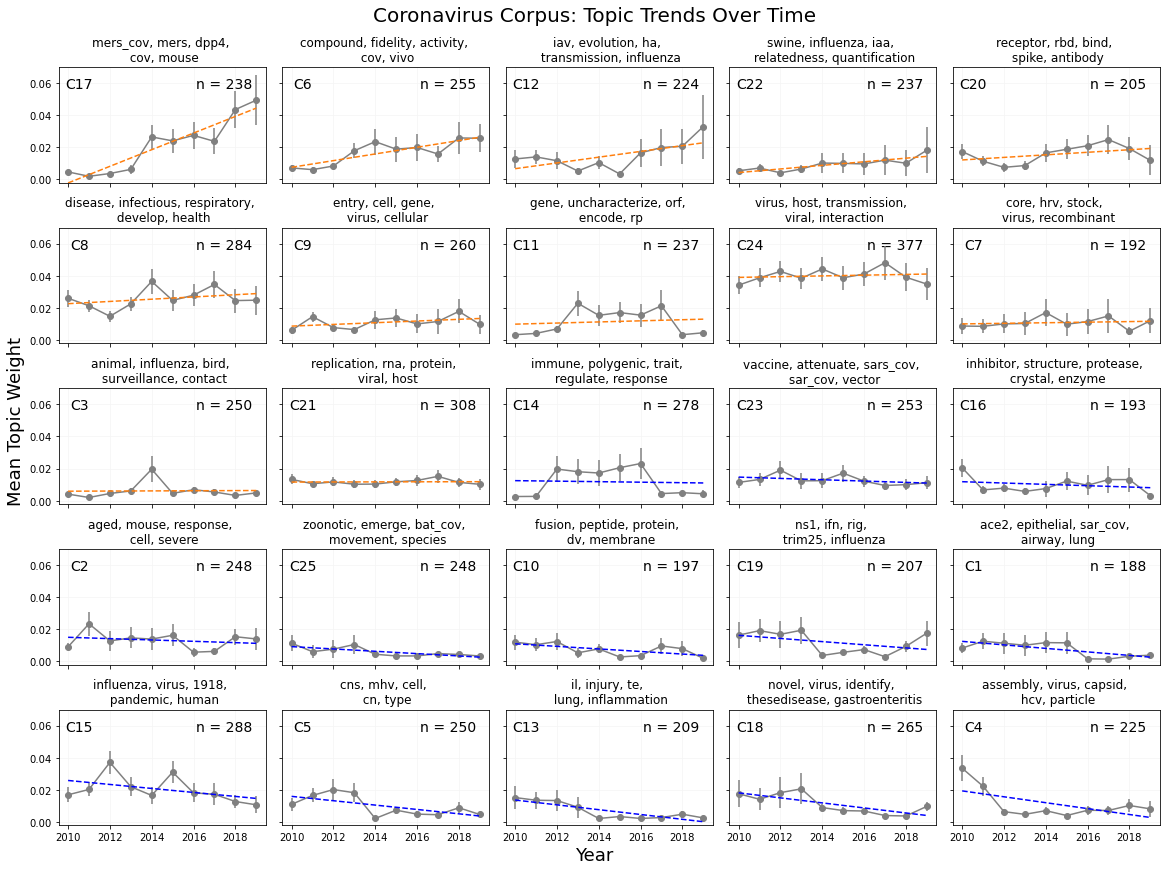

In [47]:
# set up grid
fig, ax = plt.subplots(5, 5, sharex = True, sharey = True, figsize=(16,12))
plt.ylim(bottom = -0.002, top = 0.07)  

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx+1]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = stats.linregress(topic_wts_2010_2019["START_YEAR"].values, topic_wts_2010_2019[col].values)
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.slope > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.slope)+linear_fit.intercept, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # add annotations - number of nonzero project topic weights per point
    #for k, txt in enumerate(topic_counts_filt[col]):
    #    ax[i,j].annotate(txt, xy = (topic_wts_2010_2019["START_YEAR"][k+25], topic_wts_2010_2019[col][k+25]), \
    #                    xycoords = 'data', xytext = (1,8), textcoords = "offset points")

    # put legend on two lines for topics 17, 21
    #if count == 16:
    #    ax[i,j].set_title('interagency_agreement_niaid, \n avian_influenza, basic, swine, pathogenic', \
    #                      fontsize = 12)
    #elif count == 27:
    #    ax[i,j].set_title('poultry, transmission, \n avian_influenza_virus, raptor, bird', fontsize = 12)
    #else:
    ax[i,j].set_title(new_leg[col_idx], fontsize = 12)
    
    # add topic number to each plot
    ax[i,j].text(0.10, 0.85, str(L_df['Label'].iloc[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    # add number of documents including topic to each plot - should this be dominant topic only? or some threshold?
    ax[i,j].text(0.80, 0.85, "n = " + str(n_by_topic[col_idx]), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 20)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 18)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.subplots_adjust(top=0.91)

plt.savefig("cor_topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

### Descriptive statistics on corpus

In [48]:
df["START_YEAR"].value_counts()

2009    118
2008     98
2011     97
2010     81
2012     70
2013     70
2014     69
2015     69
2016     64
2018     54
2017     47
2007     39
2019     30
2005     21
2004     20
2006     14
2001      9
1983      7
1991      6
1985      5
1977      5
2002      5
2000      3
1976      3
1999      3
1998      3
2003      3
1980      2
1975      2
1988      2
1990      1
1979      1
1994      1
Name: START_YEAR, dtype: int64

In [49]:
df["DEPARTMENT"].value_counts()

HHS     934
USDA     50
NSF      30
DOD       4
NASA      2
EPA       1
VA        1
Name: DEPARTMENT, dtype: int64

In [50]:
# filter data frame by year and repeat descriptive statistics.  Limit years to those for emerging topic analysis.

filt_df = df.copy()
filt_df["START_YEAR"] = filt_df["START_YEAR"].astype('int')

filt_df = filt_df[filt_df["START_YEAR"] > 2009]
filt_df = filt_df[filt_df["START_YEAR"] < 2020]

In [51]:
year_counts = filt_df["START_YEAR"].value_counts().sort_index()
print(year_counts)

2010    81
2011    97
2012    70
2013    70
2014    69
2015    69
2016    64
2017    47
2018    54
2019    30
Name: START_YEAR, dtype: int64


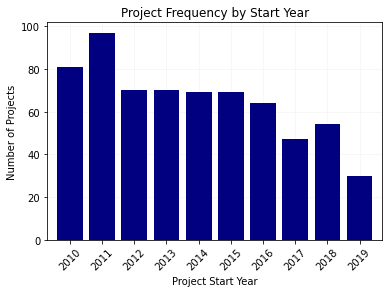

In [52]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xticks(year, rotation=45)
plt.xlim(2009.3,2019.7)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Start Year");

plt.savefig("cor_startyr_freq.png", dpi = 800, bbox_inches = "tight")

In [53]:
agency_counts = filt_df["DEPARTMENT"].value_counts()
print(agency_counts)

HHS     590
USDA     31
NSF      24
DOD       4
NASA      1
EPA       1
Name: DEPARTMENT, dtype: int64


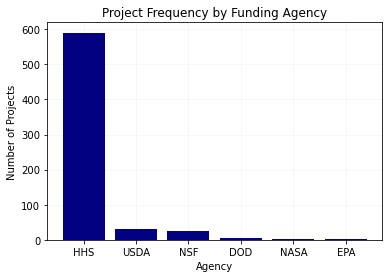

In [64]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
plt.xlabel("Agency")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Funding Agency");

plt.savefig("cor_agency_dist.png", dpi = 800, bbox_inches = "tight")

In [54]:
filt_df.pivot_table(index=['DEPARTMENT','START_YEAR'], aggfunc='size')

DEPARTMENT  START_YEAR
DOD         2014           1
            2018           2
            2019           1
EPA         2012           1
HHS         2010          75
            2011          89
            2012          65
            2013          64
            2014          60
            2015          61
            2016          56
            2017          42
            2018          49
            2019          29
NASA        2014           1
NSF         2010           2
            2011           3
            2012           4
            2013           1
            2014           1
            2015           3
            2016           4
            2017           3
            2018           3
USDA        2010           4
            2011           5
            2013           5
            2014           6
            2015           5
            2016           4
            2017           2
dtype: int64

In [55]:
filt_df.shape

(651, 33)

## Scratch work 

**try other ways to show topic prevalence, number of projects, project costs**

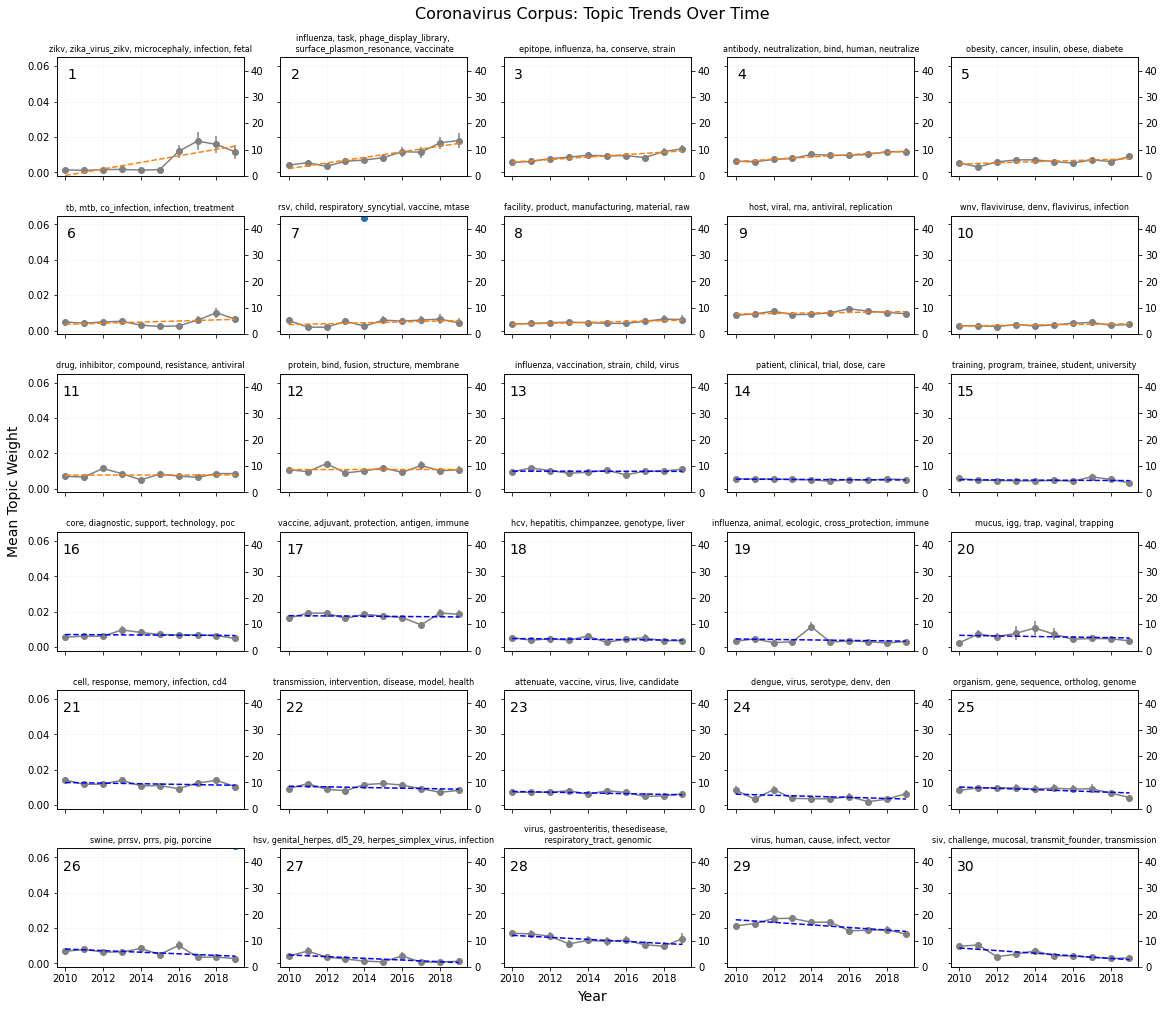

In [61]:
# dual axis approach

# set up grid
fig, ax = plt.subplots(6, 5, sharex = True, sharey = True, figsize=(16,14))
plt.ylim(bottom = -0.002, top = 0.065)

# create plot in each grid square
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # map count to i,j in grid
    i = count // 5
    j = count % 5
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[i,j].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[i,j].grid(color = "whitesmoke")
    
    # try dual axis
    ax2 = ax[i,j].twinx()
    ax2.plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax2.set_ylim(0,45)
    

    # put legend on two lines for topics 2, 28
    if count == 1:
        ax[i,j].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[i,j].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[i,j].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[i,j].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[i,j].transAxes, fontsize = 14)
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, -0.002, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.93)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()

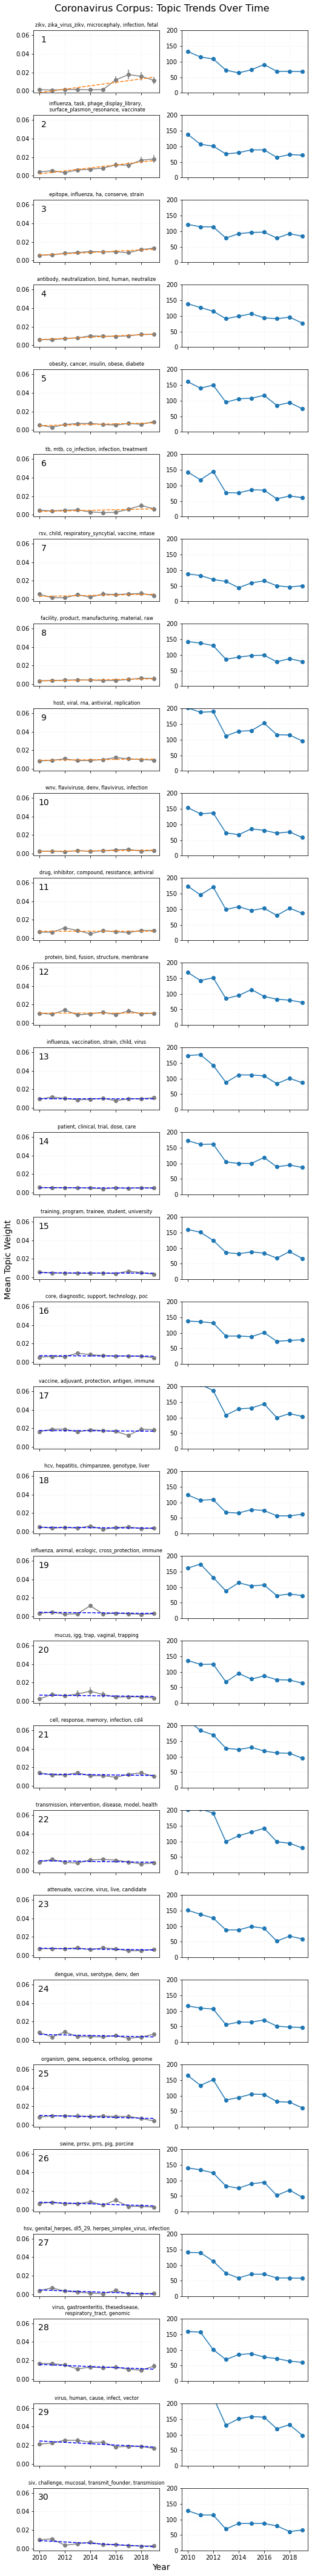

In [64]:
# try with multiple graphs per topic

# set up grid
fig, ax = plt.subplots(30, 2, sharex = True, sharey = 'col', figsize=(7,60))
#plt.ylim(bottom = -0.002, top = 0.065)

# create plots for each row
for count,col_idx in enumerate(sorted_slopes):
    
    col = topic_wts_2010_2019.columns[col_idx]
    
    # 1: mean topic weights plot
    
    linear_fit = lm().fit(
        topic_wts_2010_2019["START_YEAR"].values.reshape(-1,1), topic_wts_2010_2019[col].values.reshape(-1,1))
    
    # set color of regression line based on 'hot' or 'cold'
    if(linear_fit.coef_[0][0] > 0): # hot
        reg_line_color = '#ff7f0e'
    else: # cold
        reg_line_color = 'blue'
    
    #ax[i,j].plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], '-o', color = '#1f77b4')

    ax[count,0].errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019[col], 
            yerr = np.array(topic_wts_se_2010_2019[col]), fmt = '-o', color = 'gray', zorder = 10) 
    
    ax[count,0].plot(topic_wts_2010_2019["START_YEAR"], \
        (topic_wts_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_, \
        linestyle = 'dashed', color = reg_line_color, zorder = 20)
    
    ax[count,0].grid(color = "whitesmoke")
    
    # put title on two lines for topics 2, 28
    if count == 1:
        ax[count,0].set_title('influenza, task, phage_display_library, \n surface_plasmon_resonance, vaccinate', \
                          fontsize = 8)
    elif count == 27:
        ax[count,0].set_title('virus, gastroenteritis, thesedisease, \n respiratory_tract, genomic', fontsize = 8)
    else:
        ax[count,0].set_title(leg[col_idx-1], fontsize = 8)
    
    # add topic number to each plot
    ax[count,0].text(0.08, 0.85, str(count+1), horizontalalignment='center', verticalalignment='center', \
                 transform=ax[count,0].transAxes, fontsize = 14)
    
    ax[count,0].set_ylim(-0.002,0.065)
    
    # 2. Number of projects plot

    ax[count,1].plot(topic_wts_2010_2019["START_YEAR"], topic_counts_filt[col], '-o')
    ax[count,1].set_ylim(0,200)
    ax[count,1].grid(color = "whitesmoke")
    
    
fig.suptitle('Coronavirus Corpus: Topic Trends Over Time', fontsize = 16)
fig.text(0.5, 0, 'Year', ha='center', va='center', fontsize = 14)
fig.text(-0.002, 0.5, 'Mean Topic Weight', ha='center', va='center', rotation='vertical', fontsize = 14)
fig.tight_layout()
fig.subplots_adjust(top=0.97)

#plt.savefig("../figures/coronavirus/topic_trends.png", dpi = 800, bbox_inches = "tight")
plt.show()